In [3]:
# import modules
import pandas as pd
import numpy as np
import pytz

%matplotlib inline
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score

from statsmodels.tsa.seasonal import seasonal_decompose

from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Conv1D, MaxPooling1D, LSTM, Dense, Flatten
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization
from keras.models import load_model


from scikeras.wrappers import KerasRegressor


In [4]:
# define function to load dataset and do some preprocessing
def load_file(file):
    file_path = file
    name = pd.read_excel(file_path)
    name["Date"] = pd.to_datetime(name["Date"])
    name.index = pd.bdate_range(start=name.index[0], periods=len(name)) # This will define the frequency of data on the basis of weekdays
    name = name.set_index(name.Date) # set date as index
    name = name.tz_localize(pytz.timezone('Europe/Lisbon'))
    name.drop(columns = "Date", inplace = True)
    return name

In [5]:
# function for additive decomposition
def additive_decom(df):
    rcParams['figure.figsize'] = 18, 8  
    series = df["Close"]
    result = seasonal_decompose(series, model='additive', period=int(len(series)/series.index.year.nunique()), extrapolate_trend= "freq",) # if i have to see the yearly seasonal pattern i need to divide total data point by number of year. 
    df["Trend"] = result.trend
    df["Seasonality"] = result.seasonal
    df["Residual"] = result.resid
    df["target"] = (df["Close"].shift(-1).fillna(0))    # our target is next day closing price for current day other indicator
    fig = result.plot()
    plt.show()
    return df

In [6]:
def calculate_technical_indicators(df):
    # RSI
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    avg_gain = up.rolling(window=14).mean()
    avg_loss = down.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    # EMA
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema24 = df['Close'].ewm(span=24, adjust=False).mean()
    
    # MACD
    macd_line = ema12 - ema24
    signal_line = macd_line.ewm(span=9, adjust=False).mean()
    macd_histogram = macd_line - signal_line
    
    # Moving Averages
    ma12 = df['Close'].rolling(window=12).mean()
    ma24 = df['Close'].rolling(window=24).mean()
    
    # BIAS
    bias12 = (df['Close'] - ma12) / ma12 * 100
    bias24 = (df['Close'] - ma24) / ma24 * 100
    
    # Stochastic Oscillator
    highest_high = df['High'].rolling(window=14).max()
    lowest_low = df['Low'].rolling(window=14).min()
    k_values = 100 * ((df['Close'] - lowest_low) / (highest_high - lowest_low))
    d_values = k_values.rolling(window=3).mean()
    
    # Create a new DataFrame with the calculated indicators
    indicators = pd.DataFrame({
        'RSI': rsi,
        'EMA12': ema12,
        'EMA24': ema24,
        'MACD Line': macd_line,
        'Signal Line': signal_line,
        'MACD Histogram': macd_histogram,
        'MA12': ma12,
        'MA24': ma24,
        'BIAS12': bias12,
        'BIAS24': bias24,
        'Stochastic %K': k_values,
        'Stochastic %D': d_values
    }, index=df.index)
    
    indicator = indicators.fillna(0)
    df = df.merge(indicator, left_index=True, right_index=True)
    
    return df


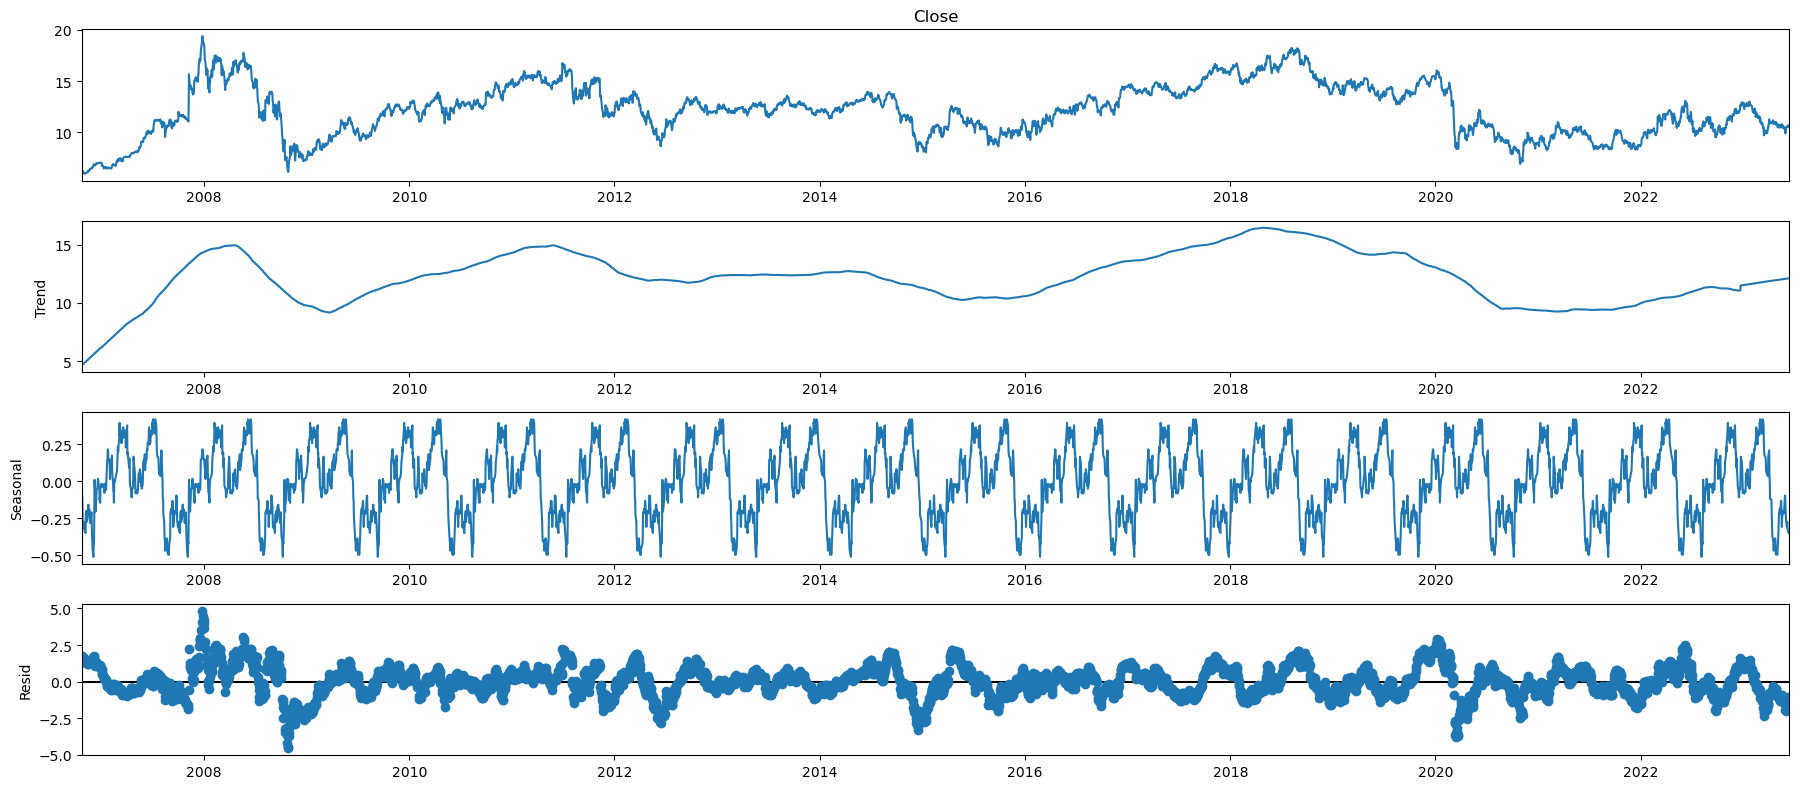

,Open,High,Low,Close,Adj Close,Volume,RSI,EMA12,EMA24,MACD Line,...,MA12,MA24,BIAS12,BIAS24,Stochastic %K,Stochastic %D,Trend,Seasonality,Residual,target
Date,,,,,,,,,,,,,,,,,,,,,
2006-10-24 00:00:00+01:00,6.012819,6.165428,6.012819,6.134906,3.417638,32465846,0.000000,6.134906,6.134906,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.646616,-0.095894,1.584184,6.256994
2006-10-25 00:00:00+01:00,6.175602,6.368908,6.165428,6.256994,3.485650,17917277,0.000000,6.153689,6.144673,0.009016,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.677897,-0.100118,1.679214,6.287516
2006-10-26 00:00:00+01:00,6.307864,6.328212,6.256994,6.287516,3.502653,9429700,0.000000,6.174277,6.156100,0.018177,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.709178,-0.169609,1.747947,6.155254
2006-10-27 00:00:00+01:00,6.297690,6.297690,6.104384,6.155254,3.428972,8365865,0.000000,6.171351,6.156033,0.015318,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.740459,-0.266583,1.681378,6.084037
2006-10-30 00:00:00+00:00,6.165428,6.175602,6.073863,6.084037,3.389299,4058752,0.000000,6.157918,6.150273,0.007645,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.771740,-0.309841,1.622138,6.094211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-06 00:00:00+01:00,10.460000,10.510000,10.285000,10.495000,10.495000,2096484,48.677241,10.421088,10.502798,-0.081710,...,10.400917,10.507333,0.904567,-0.117380,59.959925,60.960948,12.087867,-0.273891,-1.318977,10.615000
2023-06-07 00:00:00+01:00,10.490000,10.685000,10.405000,10.615000,10.615000,1986849,47.162963,10.450921,10.511774,-0.060854,...,10.412167,10.513375,1.948039,0.966624,71.971919,64.297597,12.093113,-0.313662,-1.164452,10.660000
2023-06-08 00:00:00+01:00,10.670000,10.795000,10.660000,10.660000,10.660000,1314701,46.800727,10.483087,10.523632,-0.040546,...,10.425917,10.520042,2.245205,1.330396,84.983292,72.305045,12.098359,-0.319801,-1.118559,10.690000


In [7]:
# separate features and target form dataframe

df = load_file("GALP.LS_daily_data.xlsx")
df = calculate_technical_indicators(df)
df = additive_decom(df)
df

In [8]:
# Separate features and target 
features = df[['Open', 'High', 'Low', 'Adj Close', 'Volume', 'RSI', 'EMA12',
       'EMA24', 'MACD Line', 'MA12', 'MA24',
       'BIAS12', 'BIAS24', 'Trend',
       'Seasonality', 'Residual']]
target = df["target"]

In [9]:
# Split the data into training and testing sets
# Divide the data into shorter-period sequences, preferred window size is based on parameter tuning
train_size = int(len(features) * 0.90)

train_features = features[:train_size]
test_features = features[train_size:]

train_target = target[:train_size]
test_target = target[train_size:]

In [10]:
# Scale the data usnig MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(train_features)
X_test_scaled = scaler.transform(test_features)
y_train_scaled = scaler.fit_transform(train_target.values.reshape(-1, 1))
y_test_scaled = scaler.transform(test_target.values.reshape(-1, 1))

In [11]:
# sequence of window for input
window_size = 20
# Create input sequences and corresponding labels
X_train, y_train = [], []
X_test, y_test = [], []

for i in range(window_size, len(train_features)):
    X_train.append(X_train_scaled[i-window_size:i])
    y_train.append(y_train_scaled[i])  

for i in range(window_size, len(test_features)):
    X_test.append(X_test_scaled[i-window_size:i])
    y_test.append(y_test_scaled[i])  

In [12]:
# Convert the data to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the data for input to the CNN-LSTM model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))


In [117]:
# Define the hyperparameter search space for parameter tuning
filters = [32, 48, 64, 96]
kernel_sizes = [2, 3, 4]
pool_sizes = [2, 3, 4]
units = [100, 125, 150 ]
batch_sizes = [20,40,60]

best_rmse = float('inf')  
best_params = {}

# Iterate over hyperparameter combinations
for filter_size in filters:
    for kernel_size in kernel_sizes:
        for pool_size in pool_sizes:
            for unit in units:
                for batch_size in batch_sizes:
                            # Build the model

                            model = Sequential()
                            model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu', input_shape=(window_size, X_train.shape[2])))
                            model.add(MaxPooling1D(pool_size=pool_size))
                            model.add(LSTM(unit, activation='relu'))
                            model.add(Dense(1))
                            model.compile(optimizer='adam', loss='mse')

                            # Define early stopping criteria
                            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

                            # Train the model
                            model.fit(X_train, y_train, epochs=100, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping],  verbose=1)

                            # Access the best model's weights
                            best_weights = model.get_weights()

                            # Evaluate the model on the test set
                            loss = model.evaluate(X_test, y_test, verbose=0)
                            # Make predictions
                            predicted_prices = model.predict(X_test)
                            # Inverse transform the predicted prices
                            predicted_prices = scaler.inverse_transform(predicted_prices)

                            # Inverse transform the actual prices
                            actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

                            # Claculate MSE
                            error = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
                            r2 = r2_score(actual_prices, predicted_prices)

                            print(f"MSE: {error} - R-Squared {r2}Parameters: {filter_size}, {kernel_size}, {pool_size}, {unit}, {epoch}, {batch_size}")
                            
                            # Update best MSE and best parameters if necessary
                            if error < best_rmse:
                                best_rmse = error
                                best_params = {
                                    'filter_size': filter_size,
                                    'kernel_size': kernel_size,
                                    'pool_size': pool_size,
                                    'unit': unit,
                                    'epoch': epoch,
                                    'batch_size': batch_size
                                }



Epoch 1/100
191/191 [==============================] - 5s 16ms/step - loss: 0.0069 - val_loss: 0.0034
Epoch 2/100
191/191 [==============================] - 3s 16ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 3/100
191/191 [==============================] - 3s 16ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 4/100
191/191 [==============================] - 3s 15ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 5/100
191/191 [==============================] - 3s 15ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 6/100
191/191 [==============================] - 3s 15ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 7/100
191/191 [==============================] - 3s 16ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 8/100
191/191 [==============================] - 3s 16ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 9/100
191/191 [==============================] - 3s 16ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 10/100
191/191 [==============================] - 3s 15ms/step - loss: 0.001

13/13 [==============================] - 0s 11ms/step
MSE: 0.6698791381546495 - R-Squared 0.7072948056993354Parameters: 32, 2, 2, 150, 10, 40
Epoch 1/100
64/64 [==============================] - 10s 96ms/step - loss: 0.0231 - val_loss: 0.0060
Epoch 2/100
64/64 [==============================] - 4s 62ms/step - loss: 0.0027 - val_loss: 0.0041
Epoch 3/100
64/64 [==============================] - 4s 61ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 4/100
64/64 [==============================] - 4s 61ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 5/100
64/64 [==============================] - 4s 60ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 6/100
64/64 [==============================] - 4s 62ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 7/100
64/64 [==============================] - 4s 61ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 8/100
64/64 [==============================] - 4s 61ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 9/100
64/64 [==============================] - 4s 6

64/64 [==============================] - 2s 29ms/step - loss: 0.0025 - val_loss: 0.0038
Epoch 3/100
64/64 [==============================] - 2s 28ms/step - loss: 0.0022 - val_loss: 0.0037
Epoch 4/100
64/64 [==============================] - 2s 28ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 5/100
64/64 [==============================] - 2s 27ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 6/100
64/64 [==============================] - 2s 27ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 7/100
64/64 [==============================] - 2s 26ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 8/100
64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 9/100
64/64 [==============================] - 2s 27ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 10/100
64/64 [==============================] - 2s 28ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 11/100
64/64 [==============================] - 2s 28ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 12/1

64/64 [==============================] - 2s 25ms/step - loss: 0.0024 - val_loss: 0.0039
Epoch 7/100
64/64 [==============================] - 2s 25ms/step - loss: 0.0021 - val_loss: 0.0035
Epoch 8/100
64/64 [==============================] - 2s 25ms/step - loss: 0.0022 - val_loss: 0.0035
Epoch 9/100
64/64 [==============================] - 2s 25ms/step - loss: 0.0020 - val_loss: 0.0034
Epoch 10/100
64/64 [==============================] - 2s 27ms/step - loss: 0.0019 - val_loss: 0.0034
Epoch 11/100
64/64 [==============================] - 2s 27ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 12/100
64/64 [==============================] - 2s 27ms/step - loss: 0.0018 - val_loss: 0.0036
Epoch 13/100
64/64 [==============================] - 2s 26ms/step - loss: 0.0019 - val_loss: 0.0036
Epoch 14/100
13/13 [==============================] - 0s 7ms/step
MSE: 0.7807446347558541 - R-Squared 0.6023916094471558Parameters: 32, 2, 4, 150, 10, 60
Epoch 1/100
191/191 [==============================] -

191/191 [==============================] - 5s 24ms/step - loss: 9.6427e-04 - val_loss: 0.0023
Epoch 9/100
191/191 [==============================] - 5s 25ms/step - loss: 9.8969e-04 - val_loss: 0.0023
Epoch 10/100
191/191 [==============================] - 4s 23ms/step - loss: 9.0882e-04 - val_loss: 0.0026
Epoch 11/100
191/191 [==============================] - 5s 24ms/step - loss: 9.1715e-04 - val_loss: 0.0023
Epoch 12/100
191/191 [==============================] - 5s 25ms/step - loss: 9.3416e-04 - val_loss: 0.0025
Epoch 13/100
191/191 [==============================] - 5s 24ms/step - loss: 8.8391e-04 - val_loss: 0.0024
Epoch 14/100
191/191 [==============================] - 4s 23ms/step - loss: 9.0125e-04 - val_loss: 0.0024
Epoch 15/100
191/191 [==============================] - 5s 24ms/step - loss: 9.0043e-04 - val_loss: 0.0029
Epoch 16/100
13/13 [==============================] - 1s 12ms/step
MSE: 0.6417952040101891 - R-Squared 0.7313230197945184Parameters: 32, 3, 2, 150, 10, 20
Epo

Epoch 5/100
191/191 [==============================] - 2s 13ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 6/100
191/191 [==============================] - 2s 13ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 7/100
191/191 [==============================] - 2s 12ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 8/100
191/191 [==============================] - 2s 12ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 9/100
191/191 [==============================] - 2s 12ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 10/100
191/191 [==============================] - 2s 12ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 11/100
191/191 [==============================] - 3s 13ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 12/100
191/191 [==============================] - 2s 13ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 13/100
191/191 [==============================] - 2s 13ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 14/100
13/13 [==============================] - 0s 7ms/step
MSE: 0.65956

13/13 [==============================] - 0s 8ms/step
MSE: 0.6319450907835763 - R-Squared 0.7395069069851528Parameters: 32, 3, 3, 125, 10, 60
Epoch 1/100
191/191 [==============================] - 7s 18ms/step - loss: 0.0078 - val_loss: 0.0030
Epoch 2/100
191/191 [==============================] - 3s 16ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 3/100
191/191 [==============================] - 3s 16ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 4/100
191/191 [==============================] - 3s 17ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 5/100
191/191 [==============================] - 3s 16ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 6/100
191/191 [==============================] - 3s 16ms/step - loss: 0.0010 - val_loss: 0.0024
Epoch 7/100
191/191 [==============================] - 3s 16ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 8/100
191/191 [==============================] - 3s 17ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 9/100
191/191 [======================

Epoch 1/100
96/96 [==============================] - 5s 19ms/step - loss: 0.0252 - val_loss: 0.0047
Epoch 2/100
96/96 [==============================] - 1s 14ms/step - loss: 0.0031 - val_loss: 0.0038
Epoch 3/100
96/96 [==============================] - 1s 14ms/step - loss: 0.0026 - val_loss: 0.0036
Epoch 4/100
96/96 [==============================] - 1s 14ms/step - loss: 0.0023 - val_loss: 0.0036
Epoch 5/100
96/96 [==============================] - 1s 14ms/step - loss: 0.0021 - val_loss: 0.0051
Epoch 6/100
96/96 [==============================] - 1s 14ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 7/100
96/96 [==============================] - 1s 14ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 8/100
96/96 [==============================] - 1s 14ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 9/100
96/96 [==============================] - 1s 14ms/step - loss: 0.0017 - val_loss: 0.0040
Epoch 10/100
96/96 [==============================] - 1s 15ms/step - loss: 0.0018 - val_loss: 0.0032

64/64 [==============================] - 1s 22ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 19/100
64/64 [==============================] - 1s 22ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 20/100
64/64 [==============================] - 1s 21ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 21/100
64/64 [==============================] - 1s 21ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 22/100
64/64 [==============================] - 1s 21ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 23/100
64/64 [==============================] - 1s 21ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 24/100
64/64 [==============================] - 1s 21ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 25/100
64/64 [==============================] - 1s 21ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 26/100
64/64 [==============================] - 1s 23ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 27/100
64/64 [==============================] - 1s 23ms/step - loss: 0.0011 - val_loss: 0.0026
Epo

Epoch 11/100
96/96 [==============================] - 2s 18ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 12/100
96/96 [==============================] - 2s 18ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 13/100
13/13 [==============================] - 0s 7ms/step
MSE: 0.7380338957284914 - R-Squared 0.644704145790627Parameters: 32, 4, 3, 100, 10, 40
Epoch 1/100
64/64 [==============================] - 5s 29ms/step - loss: 0.0118 - val_loss: 0.0050
Epoch 2/100
64/64 [==============================] - 1s 22ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 3/100
64/64 [==============================] - 1s 22ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 4/100
64/64 [==============================] - 1s 22ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 5/100
64/64 [==============================] - 1s 22ms/step - loss: 0.0021 - val_loss: 0.0034
Epoch 6/100
64/64 [==============================] - 1s 22ms/step - loss: 0.0024 - val_loss: 0.0035
Epoch 7/100
64/64 [==========================

96/96 [==============================] - 1s 13ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 13/100
96/96 [==============================] - 1s 13ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 14/100
96/96 [==============================] - 1s 13ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 15/100
13/13 [==============================] - 0s 5ms/step
MSE: 0.7090834427111903 - R-Squared 0.6720314401316945Parameters: 32, 4, 4, 100, 10, 40
Epoch 1/100
64/64 [==============================] - 5s 22ms/step - loss: 0.0162 - val_loss: 0.0049
Epoch 2/100
64/64 [==============================] - 1s 15ms/step - loss: 0.0026 - val_loss: 0.0043
Epoch 3/100
64/64 [==============================] - 1s 16ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 4/100
64/64 [==============================] - 1s 16ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 5/100
64/64 [==============================] - 1s 16ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 6/100
64/64 [==============================] - 1s 

Epoch 14/100
64/64 [==============================] - 2s 24ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 15/100
64/64 [==============================] - 2s 25ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 16/100
64/64 [==============================] - 2s 24ms/step - loss: 0.0013 - val_loss: 0.0033
Epoch 17/100
13/13 [==============================] - 0s 6ms/step
MSE: 0.713706425024641 - R-Squared 0.6677410131092347Parameters: 32, 4, 4, 125, 10, 60
Epoch 1/100
191/191 [==============================] - 6s 16ms/step - loss: 0.0088 - val_loss: 0.0037
Epoch 2/100
191/191 [==============================] - 3s 14ms/step - loss: 0.0025 - val_loss: 0.0038
Epoch 3/100
191/191 [==============================] - 3s 14ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch 4/100
191/191 [==============================] - 3s 14ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 5/100
191/191 [==============================] - 3s 14ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 6/100
191/191 [=============

96/96 [==============================] - 2s 25ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 3/100
96/96 [==============================] - 2s 26ms/step - loss: 0.0017 - val_loss: 0.0042
Epoch 4/100
96/96 [==============================] - 3s 26ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 5/100
96/96 [==============================] - 3s 27ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 6/100
96/96 [==============================] - 3s 27ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 7/100
96/96 [==============================] - 2s 26ms/step - loss: 0.0013 - val_loss: 0.0035
Epoch 8/100
96/96 [==============================] - 2s 25ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 9/100
96/96 [==============================] - 2s 25ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 10/100
96/96 [==============================] - 2s 25ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 11/100
96/96 [==============================] - 3s 27ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 12/1

Epoch 10/100
64/64 [==============================] - 3s 48ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 11/100
64/64 [==============================] - 3s 48ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 12/100
64/64 [==============================] - 3s 49ms/step - loss: 0.0012 - val_loss: 0.0030
Epoch 13/100
64/64 [==============================] - 3s 50ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 14/100
13/13 [==============================] - 1s 13ms/step
MSE: 0.7029823882364613 - R-Squared 0.6776509361841415Parameters: 48, 2, 2, 150, 10, 60
Epoch 1/100
191/191 [==============================] - 6s 16ms/step - loss: 0.0078 - val_loss: 0.0033
Epoch 2/100
191/191 [==============================] - 3s 14ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 3/100
191/191 [==============================] - 3s 15ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 4/100
191/191 [==============================] - 3s 14ms/step - loss: 0.0015 - val_loss: 0.0037
Epoch 5/100
191/191 [============

64/64 [==============================] - 2s 27ms/step - loss: 0.0026 - val_loss: 0.0034
Epoch 3/100
64/64 [==============================] - 2s 28ms/step - loss: 0.0021 - val_loss: 0.0034
Epoch 4/100
64/64 [==============================] - 2s 27ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 5/100
64/64 [==============================] - 2s 26ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 6/100
64/64 [==============================] - 2s 26ms/step - loss: 0.0018 - val_loss: 0.0033
Epoch 7/100
64/64 [==============================] - 2s 26ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 8/100
64/64 [==============================] - 2s 26ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 9/100
64/64 [==============================] - 2s 25ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 10/100
64/64 [==============================] - 2s 27ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 11/100
64/64 [==============================] - 2s 28ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 12/1

64/64 [==============================] - 5s 32ms/step - loss: 0.0173 - val_loss: 0.0063
Epoch 2/100
64/64 [==============================] - 2s 26ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 3/100
64/64 [==============================] - 2s 27ms/step - loss: 0.0027 - val_loss: 0.0036
Epoch 4/100
64/64 [==============================] - 2s 27ms/step - loss: 0.0025 - val_loss: 0.0037
Epoch 5/100
64/64 [==============================] - 2s 27ms/step - loss: 0.0022 - val_loss: 0.0036
Epoch 6/100
64/64 [==============================] - 2s 25ms/step - loss: 0.0020 - val_loss: 0.0034
Epoch 7/100
64/64 [==============================] - 2s 25ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 8/100
64/64 [==============================] - 2s 25ms/step - loss: 0.0018 - val_loss: 0.0034
Epoch 9/100
64/64 [==============================] - 2s 25ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 10/100
64/64 [==============================] - 2s 25ms/step - loss: 0.0021 - val_loss: 0.0035
Epoch 11/10

96/96 [==============================] - 2s 23ms/step - loss: 7.9556e-04 - val_loss: 0.0029
Epoch 34/100
13/13 [==============================] - 0s 9ms/step
MSE: 0.6279539231251906 - R-Squared 0.7427869023605167Parameters: 48, 3, 2, 100, 10, 40
Epoch 1/100
64/64 [==============================] - 6s 40ms/step - loss: 0.0218 - val_loss: 0.0036
Epoch 2/100
64/64 [==============================] - 2s 34ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 3/100
64/64 [==============================] - 2s 33ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 4/100
64/64 [==============================] - 2s 29ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 5/100
64/64 [==============================] - 2s 28ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 6/100
64/64 [==============================] - 2s 28ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 7/100
64/64 [==============================] - 2s 28ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 8/100
64/64 [==============================] - 2

64/64 [==============================] - 6s 44ms/step - loss: 0.0256 - val_loss: 0.0049
Epoch 2/100
64/64 [==============================] - 2s 37ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 3/100
64/64 [==============================] - 2s 38ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 4/100
64/64 [==============================] - 2s 39ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 5/100
64/64 [==============================] - 2s 39ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 6/100
64/64 [==============================] - 2s 38ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 7/100
64/64 [==============================] - 2s 37ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 8/100
64/64 [==============================] - 2s 37ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 9/100
64/64 [==============================] - 2s 37ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 10/100
64/64 [==============================] - 2s 39ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 11/10

64/64 [==============================] - 2s 28ms/step - loss: 9.6048e-04 - val_loss: 0.0027
Epoch 16/100
64/64 [==============================] - 2s 28ms/step - loss: 9.4327e-04 - val_loss: 0.0023
Epoch 17/100
64/64 [==============================] - 2s 28ms/step - loss: 8.8451e-04 - val_loss: 0.0023
Epoch 18/100
64/64 [==============================] - 2s 28ms/step - loss: 9.4133e-04 - val_loss: 0.0025
Epoch 19/100
64/64 [==============================] - 2s 28ms/step - loss: 8.8537e-04 - val_loss: 0.0024
Epoch 20/100
64/64 [==============================] - 2s 30ms/step - loss: 9.2847e-04 - val_loss: 0.0024
Epoch 21/100
13/13 [==============================] - 0s 7ms/step
MSE: 0.6463026209589555 - R-Squared 0.7275358558675336Parameters: 48, 3, 3, 100, 10, 60
Epoch 1/100
191/191 [==============================] - 7s 18ms/step - loss: 0.0058 - val_loss: 0.0029
Epoch 2/100
191/191 [==============================] - 3s 15ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 3/100
191/191 [====

Epoch 5/100
191/191 [==============================] - 2s 11ms/step - loss: 0.0022 - val_loss: 0.0045
Epoch 6/100
191/191 [==============================] - 2s 12ms/step - loss: 0.0021 - val_loss: 0.0035
Epoch 7/100
191/191 [==============================] - 2s 12ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 8/100
191/191 [==============================] - 2s 11ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 9/100
191/191 [==============================] - 2s 11ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 10/100
191/191 [==============================] - 2s 11ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 11/100
191/191 [==============================] - 2s 12ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 12/100
191/191 [==============================] - 2s 11ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 13/100
191/191 [==============================] - 2s 12ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 14/100
191/191 [==============================] - 2s 12ms/step - loss: 0

Epoch 11/100
13/13 [==============================] - 0s 7ms/step
MSE: 0.756381672779025 - R-Squared 0.6268190050849932Parameters: 48, 3, 4, 150, 10, 40
Epoch 1/100
64/64 [==============================] - 5s 30ms/step - loss: 0.0174 - val_loss: 0.0045
Epoch 2/100
64/64 [==============================] - 1s 23ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 3/100
64/64 [==============================] - 1s 23ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 4/100
64/64 [==============================] - 1s 23ms/step - loss: 0.0022 - val_loss: 0.0038
Epoch 5/100
64/64 [==============================] - 1s 23ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 6/100
64/64 [==============================] - 1s 23ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 7/100
64/64 [==============================] - 1s 23ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 8/100
64/64 [==============================] - 2s 24ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 9/100
64/64 [============================

64/64 [==============================] - 2s 36ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 25/100
64/64 [==============================] - 2s 35ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 26/100
64/64 [==============================] - 2s 36ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 27/100
64/64 [==============================] - 2s 37ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 28/100
13/13 [==============================] - 1s 9ms/step
MSE: 0.6711787775174008 - R-Squared 0.706157943270495Parameters: 48, 4, 2, 125, 10, 60
Epoch 1/100
191/191 [==============================] - 7s 22ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 2/100
191/191 [==============================] - 4s 20ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 3/100
191/191 [==============================] - 4s 21ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 4/100
191/191 [==============================] - 4s 21ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 5/100
191/191 [===========================

96/96 [==============================] - 2s 17ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 16/100
96/96 [==============================] - 2s 17ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 17/100
96/96 [==============================] - 2s 17ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 18/100
96/96 [==============================] - 2s 17ms/step - loss: 0.0015 - val_loss: 0.0035
Epoch 19/100
96/96 [==============================] - 2s 17ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 20/100
96/96 [==============================] - 2s 18ms/step - loss: 0.0014 - val_loss: 0.0033
Epoch 21/100
96/96 [==============================] - 2s 18ms/step - loss: 0.0015 - val_loss: 0.0037
Epoch 22/100
13/13 [==============================] - 1s 7ms/step
MSE: 0.7326609643637766 - R-Squared 0.649858465948788Parameters: 48, 4, 3, 125, 10, 40
Epoch 1/100
64/64 [==============================] - 5s 28ms/step - loss: 0.0138 - val_loss: 0.0049
Epoch 2/100
64/64 [==============================] - 

Epoch 15/100
13/13 [==============================] - 0s 5ms/step
MSE: 0.7114214203744109 - R-Squared 0.6698651301234602Parameters: 48, 4, 4, 100, 10, 60
Epoch 1/100
191/191 [==============================] - 7s 17ms/step - loss: 0.0081 - val_loss: 0.0045
Epoch 2/100
191/191 [==============================] - 3s 15ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 3/100
191/191 [==============================] - 3s 14ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 4/100
191/191 [==============================] - 3s 14ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 5/100
191/191 [==============================] - 3s 14ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 6/100
191/191 [==============================] - 3s 14ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 7/100
191/191 [==============================] - 3s 15ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 8/100
191/191 [==============================] - 3s 15ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 9/100
191/191 [=========

96/96 [==============================] - 3s 36ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 9/100
96/96 [==============================] - 3s 36ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 10/100
96/96 [==============================] - 4s 37ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 11/100
96/96 [==============================] - 3s 36ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 12/100
13/13 [==============================] - 0s 11ms/step
MSE: 0.6879056361355086 - R-Squared 0.6913294050258524Parameters: 64, 2, 2, 100, 10, 40
Epoch 1/100
64/64 [==============================] - 7s 53ms/step - loss: 0.0184 - val_loss: 0.0046
Epoch 2/100
64/64 [==============================] - 3s 46ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 3/100
64/64 [==============================] - 3s 44ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 4/100
64/64 [==============================] - 3s 44ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 5/100
64/64 [==============================] - 3s

Epoch 1/100
191/191 [==============================] - 8s 24ms/step - loss: 0.0069 - val_loss: 0.0029
Epoch 2/100
191/191 [==============================] - 4s 20ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 3/100
191/191 [==============================] - 4s 20ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 4/100
191/191 [==============================] - 4s 21ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 5/100
191/191 [==============================] - 4s 21ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 6/100
191/191 [==============================] - 4s 20ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 7/100
191/191 [==============================] - 4s 20ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 8/100
191/191 [==============================] - 4s 21ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 9/100
191/191 [==============================] - 4s 21ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 10/100
191/191 [==============================] - 4s 21ms/step - loss: 0.001

191/191 [==============================] - 3s 15ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 19/100
191/191 [==============================] - 3s 15ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 20/100
13/13 [==============================] - 0s 8ms/step
MSE: 0.6815473184175945 - R-Squared 0.6970091242408761Parameters: 64, 2, 3, 125, 10, 20
Epoch 1/100
96/96 [==============================] - 7s 36ms/step - loss: 0.0116 - val_loss: 0.0038
Epoch 2/100
96/96 [==============================] - 3s 31ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch 3/100
96/96 [==============================] - 3s 31ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 4/100
96/96 [==============================] - 3s 30ms/step - loss: 0.0015 - val_loss: 0.0039
Epoch 5/100
96/96 [==============================] - 3s 30ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 6/100
96/96 [==============================] - 3s 30ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 7/100
96/96 [==============================] - 

96/96 [==============================] - 2s 17ms/step - loss: 0.0022 - val_loss: 0.0037
Epoch 6/100
96/96 [==============================] - 2s 17ms/step - loss: 0.0023 - val_loss: 0.0037
Epoch 7/100
96/96 [==============================] - 2s 18ms/step - loss: 0.0021 - val_loss: 0.0036
Epoch 8/100
96/96 [==============================] - 2s 18ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 9/100
96/96 [==============================] - 2s 19ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 10/100
96/96 [==============================] - 2s 18ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 11/100
96/96 [==============================] - 2s 17ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 12/100
96/96 [==============================] - 2s 17ms/step - loss: 0.0017 - val_loss: 0.0040
Epoch 13/100
96/96 [==============================] - 2s 17ms/step - loss: 0.0020 - val_loss: 0.0034
Epoch 14/100
96/96 [==============================] - 2s 17ms/step - loss: 0.0019 - val_loss: 0.0037
Epoch 1

Epoch 1/100
96/96 [==============================] - 7s 36ms/step - loss: 0.0140 - val_loss: 0.0033
Epoch 2/100
96/96 [==============================] - 3s 30ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 3/100
96/96 [==============================] - 3s 30ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 4/100
96/96 [==============================] - 3s 30ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 5/100
96/96 [==============================] - 3s 30ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 6/100
96/96 [==============================] - 3s 31ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 7/100
96/96 [==============================] - 3s 31ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 8/100
96/96 [==============================] - 3s 30ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 9/100
96/96 [==============================] - 3s 30ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 10/100
96/96 [==============================] - 3s 30ms/step - loss: 0.0012 - val_loss: 0.0024

96/96 [==============================] - 4s 45ms/step - loss: 7.8835e-04 - val_loss: 0.0022
Epoch 25/100
96/96 [==============================] - 4s 46ms/step - loss: 8.1538e-04 - val_loss: 0.0022
Epoch 26/100
96/96 [==============================] - 4s 44ms/step - loss: 8.2852e-04 - val_loss: 0.0022
Epoch 27/100
96/96 [==============================] - 4s 44ms/step - loss: 7.9225e-04 - val_loss: 0.0024
Epoch 28/100
96/96 [==============================] - 4s 45ms/step - loss: 8.2654e-04 - val_loss: 0.0025
Epoch 29/100
96/96 [==============================] - 4s 46ms/step - loss: 8.3302e-04 - val_loss: 0.0023
Epoch 30/100
13/13 [==============================] - 1s 13ms/step
MSE: 0.6273291698387924 - R-Squared 0.7432984519640813Parameters: 64, 3, 2, 150, 10, 40
Epoch 1/100
64/64 [==============================] - 7s 57ms/step - loss: 0.0128 - val_loss: 0.0033
Epoch 2/100
64/64 [==============================] - 3s 49ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 3/100
64/64 [=========

Epoch 7/100
64/64 [==============================] - 2s 37ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 8/100
64/64 [==============================] - 2s 37ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 9/100
64/64 [==============================] - 2s 37ms/step - loss: 0.0010 - val_loss: 0.0026
Epoch 10/100
64/64 [==============================] - 2s 36ms/step - loss: 0.0010 - val_loss: 0.0024
Epoch 11/100
64/64 [==============================] - 2s 36ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 12/100
64/64 [==============================] - 2s 36ms/step - loss: 9.8550e-04 - val_loss: 0.0024
Epoch 13/100
64/64 [==============================] - 2s 36ms/step - loss: 9.6052e-04 - val_loss: 0.0024
Epoch 14/100
64/64 [==============================] - 2s 36ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 15/100
64/64 [==============================] - 2s 37ms/step - loss: 9.9304e-04 - val_loss: 0.0024
Epoch 16/100
64/64 [==============================] - 2s 37ms/step - loss: 9.1682e

191/191 [==============================] - 3s 13ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 8/100
191/191 [==============================] - 3s 13ms/step - loss: 0.0018 - val_loss: 0.0036
Epoch 9/100
191/191 [==============================] - 3s 14ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 10/100
191/191 [==============================] - 3s 14ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 11/100
191/191 [==============================] - 3s 14ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 12/100
191/191 [==============================] - 3s 13ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 13/100
191/191 [==============================] - 3s 13ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 14/100
191/191 [==============================] - 3s 13ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 15/100
191/191 [==============================] - 3s 14ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 16/100
191/191 [==============================] - 3s 14ms/step - loss: 0.0015 - va

Epoch 1/100
191/191 [==============================] - 7s 20ms/step - loss: 0.0050 - val_loss: 0.0033
Epoch 2/100
191/191 [==============================] - 3s 17ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 3/100
191/191 [==============================] - 3s 16ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 4/100
191/191 [==============================] - 3s 16ms/step - loss: 0.0016 - val_loss: 0.0038
Epoch 5/100
191/191 [==============================] - 3s 16ms/step - loss: 0.0018 - val_loss: 0.0054
Epoch 6/100
191/191 [==============================] - 3s 17ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 7/100
191/191 [==============================] - 3s 17ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 8/100
191/191 [==============================] - 3s 16ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 9/100
191/191 [==============================] - 3s 16ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 10/100
191/191 [==============================] - 3s 16ms/step - loss: 0.001

64/64 [==============================] - 5s 37ms/step - loss: 0.0213 - val_loss: 0.0040
Epoch 2/100
64/64 [==============================] - 2s 30ms/step - loss: 0.0025 - val_loss: 0.0035
Epoch 3/100
64/64 [==============================] - 2s 30ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 4/100
64/64 [==============================] - 2s 31ms/step - loss: 0.0018 - val_loss: 0.0033
Epoch 5/100
64/64 [==============================] - 2s 31ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 6/100
64/64 [==============================] - 2s 32ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 7/100
64/64 [==============================] - 2s 31ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 8/100
64/64 [==============================] - 2s 30ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 9/100
64/64 [==============================] - 2s 30ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 10/100
64/64 [==============================] - 2s 30ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 11/10

13/13 [==============================] - 0s 7ms/step
MSE: 0.7342376036459604 - R-Squared 0.6483498803723728Parameters: 64, 4, 3, 100, 10, 60
Epoch 1/100
191/191 [==============================] - 6s 18ms/step - loss: 0.0080 - val_loss: 0.0040
Epoch 2/100
191/191 [==============================] - 3s 16ms/step - loss: 0.0025 - val_loss: 0.0034
Epoch 3/100
191/191 [==============================] - 3s 15ms/step - loss: 0.0022 - val_loss: 0.0038
Epoch 4/100
191/191 [==============================] - 3s 15ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 5/100
191/191 [==============================] - 3s 15ms/step - loss: 0.0019 - val_loss: 0.0034
Epoch 6/100
191/191 [==============================] - 3s 15ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 7/100
191/191 [==============================] - 3s 15ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 8/100
191/191 [==============================] - 3s 16ms/step - loss: 0.0017 - val_loss: 0.0034
Epoch 9/100
191/191 [======================

96/96 [==============================] - 3s 31ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 9/100
96/96 [==============================] - 3s 31ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 10/100
96/96 [==============================] - 3s 29ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 11/100
13/13 [==============================] - 0s 9ms/step
MSE: 0.7425718038299289 - R-Squared 0.6403215376903739Parameters: 64, 4, 3, 150, 10, 40
Epoch 1/100
64/64 [==============================] - 6s 42ms/step - loss: 0.0148 - val_loss: 0.0050
Epoch 2/100
64/64 [==============================] - 2s 34ms/step - loss: 0.0031 - val_loss: 0.0039
Epoch 3/100
64/64 [==============================] - 2s 33ms/step - loss: 0.0026 - val_loss: 0.0034
Epoch 4/100
64/64 [==============================] - 2s 33ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 5/100
64/64 [==============================] - 2s 33ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 6/100
64/64 [==============================] - 2s 3

96/96 [==============================] - 2s 20ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 7/100
96/96 [==============================] - 2s 20ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 8/100
96/96 [==============================] - 2s 20ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 9/100
96/96 [==============================] - 2s 19ms/step - loss: 0.0013 - val_loss: 0.0037
Epoch 10/100
13/13 [==============================] - 0s 7ms/step
MSE: 0.7081938652281257 - R-Squared 0.6728538269467139Parameters: 64, 4, 4, 150, 10, 40
Epoch 1/100
64/64 [==============================] - 5s 29ms/step - loss: 0.0170 - val_loss: 0.0038
Epoch 2/100
64/64 [==============================] - 1s 21ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 3/100
64/64 [==============================] - 1s 22ms/step - loss: 0.0021 - val_loss: 0.0035
Epoch 4/100
64/64 [==============================] - 1s 22ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 5/100
64/64 [==============================] - 1s 22

13/13 [==============================] - 0s 12ms/step
MSE: 0.6805143172765644 - R-Squared 0.6979268968360877Parameters: 96, 2, 2, 100, 10, 60
Epoch 1/100
191/191 [==============================] - 9s 31ms/step - loss: 0.0059 - val_loss: 0.0029
Epoch 2/100
191/191 [==============================] - 5s 27ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 3/100
191/191 [==============================] - 5s 27ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 4/100
191/191 [==============================] - 5s 28ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 5/100
191/191 [==============================] - 5s 28ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 6/100
191/191 [==============================] - 5s 27ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 7/100
191/191 [==============================] - 5s 28ms/step - loss: 0.0014 - val_loss: 0.0033
Epoch 8/100
191/191 [==============================] - 5s 28ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 9/100
191/191 [=====================

Epoch 17/100
96/96 [==============================] - 3s 33ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 18/100
13/13 [==============================] - 1s 15ms/step
MSE: 0.6771099562848508 - R-Squared 0.7009416566912543Parameters: 96, 2, 2, 150, 10, 40
Epoch 1/100
64/64 [==============================] - 8s 75ms/step - loss: 0.0152 - val_loss: 0.0035
Epoch 2/100
64/64 [==============================] - 4s 70ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 3/100
64/64 [==============================] - 5s 71ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 4/100
64/64 [==============================] - 4s 69ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 5/100
64/64 [==============================] - 4s 68ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 6/100
64/64 [==============================] - 5s 71ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 7/100
64/64 [==============================] - 4s 70ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 8/100
64/64 [=========================

64/64 [==============================] - 3s 41ms/step - loss: 0.0024 - val_loss: 0.0039
Epoch 3/100
64/64 [==============================] - 3s 41ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 4/100
64/64 [==============================] - 3s 41ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 5/100
64/64 [==============================] - 3s 42ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 6/100
64/64 [==============================] - 3s 43ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 7/100
64/64 [==============================] - 3s 42ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 8/100
64/64 [==============================] - 3s 41ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 9/100
64/64 [==============================] - 3s 41ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 10/100
64/64 [==============================] - 3s 41ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 11/100
64/64 [==============================] - 3s 42ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 12/1

96/96 [==============================] - 2s 20ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 8/100
96/96 [==============================] - 2s 20ms/step - loss: 0.0021 - val_loss: 0.0037
Epoch 9/100
96/96 [==============================] - 2s 21ms/step - loss: 0.0018 - val_loss: 0.0034
Epoch 10/100
96/96 [==============================] - 2s 21ms/step - loss: 0.0019 - val_loss: 0.0035
Epoch 11/100
96/96 [==============================] - 2s 21ms/step - loss: 0.0019 - val_loss: 0.0034
Epoch 12/100
96/96 [==============================] - 2s 22ms/step - loss: 0.0017 - val_loss: 0.0035
Epoch 13/100
96/96 [==============================] - 2s 21ms/step - loss: 0.0017 - val_loss: 0.0036
Epoch 14/100
13/13 [==============================] - 0s 7ms/step
MSE: 0.7803050371195198 - R-Squared 0.6028392295622506Parameters: 96, 2, 4, 150, 10, 40
Epoch 1/100
64/64 [==============================] - 5s 30ms/step - loss: 0.0224 - val_loss: 0.0053
Epoch 2/100
64/64 [==============================] - 2

191/191 [==============================] - 7s 37ms/step - loss: 9.7224e-04 - val_loss: 0.0024
Epoch 8/100
191/191 [==============================] - 7s 36ms/step - loss: 9.7867e-04 - val_loss: 0.0023
Epoch 9/100
191/191 [==============================] - 7s 37ms/step - loss: 9.2489e-04 - val_loss: 0.0025
Epoch 10/100
191/191 [==============================] - 7s 36ms/step - loss: 9.9179e-04 - val_loss: 0.0023
Epoch 11/100
191/191 [==============================] - 7s 37ms/step - loss: 9.6483e-04 - val_loss: 0.0023
Epoch 12/100
191/191 [==============================] - 7s 37ms/step - loss: 8.6818e-04 - val_loss: 0.0022
Epoch 13/100
191/191 [==============================] - 7s 36ms/step - loss: 9.0523e-04 - val_loss: 0.0023
Epoch 14/100
191/191 [==============================] - 7s 37ms/step - loss: 9.3992e-04 - val_loss: 0.0022
Epoch 15/100
191/191 [==============================] - 7s 36ms/step - loss: 8.9502e-04 - val_loss: 0.0022
Epoch 16/100
191/191 [==============================

Epoch 14/100
191/191 [==============================] - 3s 17ms/step - loss: 0.0010 - val_loss: 0.0024
Epoch 15/100
191/191 [==============================] - 3s 16ms/step - loss: 9.5265e-04 - val_loss: 0.0024
Epoch 16/100
13/13 [==============================] - 0s 8ms/step
MSE: 0.6334790465360138 - R-Squared 0.7382407531634827Parameters: 96, 3, 3, 100, 10, 20
Epoch 1/100
96/96 [==============================] - 6s 26ms/step - loss: 0.0104 - val_loss: 0.0035
Epoch 2/100
96/96 [==============================] - 2s 21ms/step - loss: 0.0022 - val_loss: 0.0032
Epoch 3/100
96/96 [==============================] - 2s 21ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 4/100
96/96 [==============================] - 2s 21ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 5/100
96/96 [==============================] - 2s 20ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 6/100
96/96 [==============================] - 2s 21ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 7/100
96/96 [=================

191/191 [==============================] - 3s 15ms/step - loss: 9.3474e-04 - val_loss: 0.0024
Epoch 20/100
191/191 [==============================] - 3s 14ms/step - loss: 8.8813e-04 - val_loss: 0.0024
Epoch 21/100
191/191 [==============================] - 3s 14ms/step - loss: 9.0206e-04 - val_loss: 0.0022
Epoch 22/100
191/191 [==============================] - 3s 14ms/step - loss: 9.4381e-04 - val_loss: 0.0022
Epoch 23/100
191/191 [==============================] - 3s 15ms/step - loss: 8.7593e-04 - val_loss: 0.0022
Epoch 24/100
191/191 [==============================] - 3s 15ms/step - loss: 0.0010 - val_loss: 0.0024
Epoch 25/100
191/191 [==============================] - 3s 15ms/step - loss: 9.3874e-04 - val_loss: 0.0024
Epoch 26/100
191/191 [==============================] - 3s 14ms/step - loss: 9.2796e-04 - val_loss: 0.0022
Epoch 27/100
191/191 [==============================] - 3s 14ms/step - loss: 8.7863e-04 - val_loss: 0.0022
Epoch 28/100
191/191 [==============================] 

Epoch 1/100
191/191 [==============================] - 8s 24ms/step - loss: 0.0060 - val_loss: 0.0035
Epoch 2/100
191/191 [==============================] - 4s 21ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 3/100
191/191 [==============================] - 4s 21ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 4/100
191/191 [==============================] - 4s 21ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 5/100
191/191 [==============================] - 4s 22ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 6/100
191/191 [==============================] - 4s 21ms/step - loss: 0.0010 - val_loss: 0.0024
Epoch 7/100
191/191 [==============================] - 4s 21ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 8/100
13/13 [==============================] - 1s 10ms/step
MSE: 0.6562088265309027 - R-Squared 0.7191194550731586Parameters: 96, 3, 3, 150, 10, 20
Epoch 1/100
96/96 [==============================] - 6s 32ms/step - loss: 0.0093 - val_loss: 0.0030
Epoch 2/100
96/96 [=============

13/13 [==============================] - 0s 7ms/step
MSE: 0.7261413456696885 - R-Squared 0.65606224272025Parameters: 96, 3, 4, 125, 10, 40
Epoch 1/100
64/64 [==============================] - 5s 30ms/step - loss: 0.0205 - val_loss: 0.0052
Epoch 2/100
64/64 [==============================] - 2s 24ms/step - loss: 0.0033 - val_loss: 0.0042
Epoch 3/100
64/64 [==============================] - 2s 24ms/step - loss: 0.0029 - val_loss: 0.0038
Epoch 4/100
64/64 [==============================] - 2s 24ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 5/100
64/64 [==============================] - 2s 24ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 6/100
64/64 [==============================] - 2s 24ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 7/100
64/64 [==============================] - 1s 23ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 8/100
64/64 [==============================] - 1s 23ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 9/100
64/64 [==============================] - 1s 23ms/

96/96 [==============================] - 3s 28ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 4/100
96/96 [==============================] - 3s 27ms/step - loss: 0.0017 - val_loss: 0.0033
Epoch 5/100
96/96 [==============================] - 3s 28ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 6/100
96/96 [==============================] - 3s 28ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 7/100
96/96 [==============================] - 3s 29ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 8/100
96/96 [==============================] - 3s 29ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 9/100
96/96 [==============================] - 3s 28ms/step - loss: 0.0013 - val_loss: 0.0037
Epoch 10/100
96/96 [==============================] - 3s 27ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 11/100
96/96 [==============================] - 3s 27ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 12/100
96/96 [==============================] - 3s 27ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 13/

191/191 [==============================] - 4s 22ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 15/100
191/191 [==============================] - 4s 21ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 16/100
191/191 [==============================] - 4s 20ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 17/100
191/191 [==============================] - 4s 20ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 18/100
191/191 [==============================] - 4s 21ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 19/100
13/13 [==============================] - 0s 10ms/step
MSE: 0.7149753326896774 - R-Squared 0.6665585079509777Parameters: 96, 4, 3, 125, 10, 20
Epoch 1/100
96/96 [==============================] - 6s 32ms/step - loss: 0.0105 - val_loss: 0.0042
Epoch 2/100
96/96 [==============================] - 3s 28ms/step - loss: 0.0025 - val_loss: 0.0039
Epoch 3/100
96/96 [==============================] - 3s 28ms/step - loss: 0.0022 - val_loss: 0.0036
Epoch 4/100
96/96 [========================

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 9/100
64/64 [==============================] - 2s 28ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 10/100
64/64 [==============================] - 2s 28ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 11/100
64/64 [==============================] - 2s 28ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 12/100
64/64 [==============================] - 2s 28ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 13/100
64/64 [==============================] - 2s 27ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 14/100
64/64 [==============================] - 2s 27ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 15/100
64/64 [==============================] - 2s 27ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 16/100
64/64 [==============================] - 2s 27ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 17/100
64/64 [==============================] - 2s 27ms/step - loss: 0.0013 - val_loss: 0.0028
Epoc

"# Plot the desired output and predicted prices against the dates\nplt.plot(test_features[window_size:].index, actual_prices, label='Closing Price')\nplt.plot(test_features[window_size:].index, predicted_prices, label='Predicted Prices')\n\n# Add labels and title to the plot\nplt.xlabel('Date')\nplt.ylabel('Value')\nplt.legend()\nplt.title('Closing Price vs. Predicted Prices')\nplt.show()\n"

In [118]:
print(best_rmse)
print(best_params)
# best_parameter for model:
# {'filter_size': 64, 'kernel_size': 3, 'pool_size': 2, 'unit': 125, 'epoch': 10, 'batch_size': 20}

0.6226302252554354
{'filter_size': 64, 'kernel_size': 3, 'pool_size': 2, 'unit': 150, 'epoch': 10, 'batch_size': 20}


In [119]:
# Save the trained model
model.save('GALP_retuned.h5')

119/119 [==============================] - 0s 4ms/step
RMSE tarin is:  0.5177250412217541
RMSE test is:  0.7240516178453051


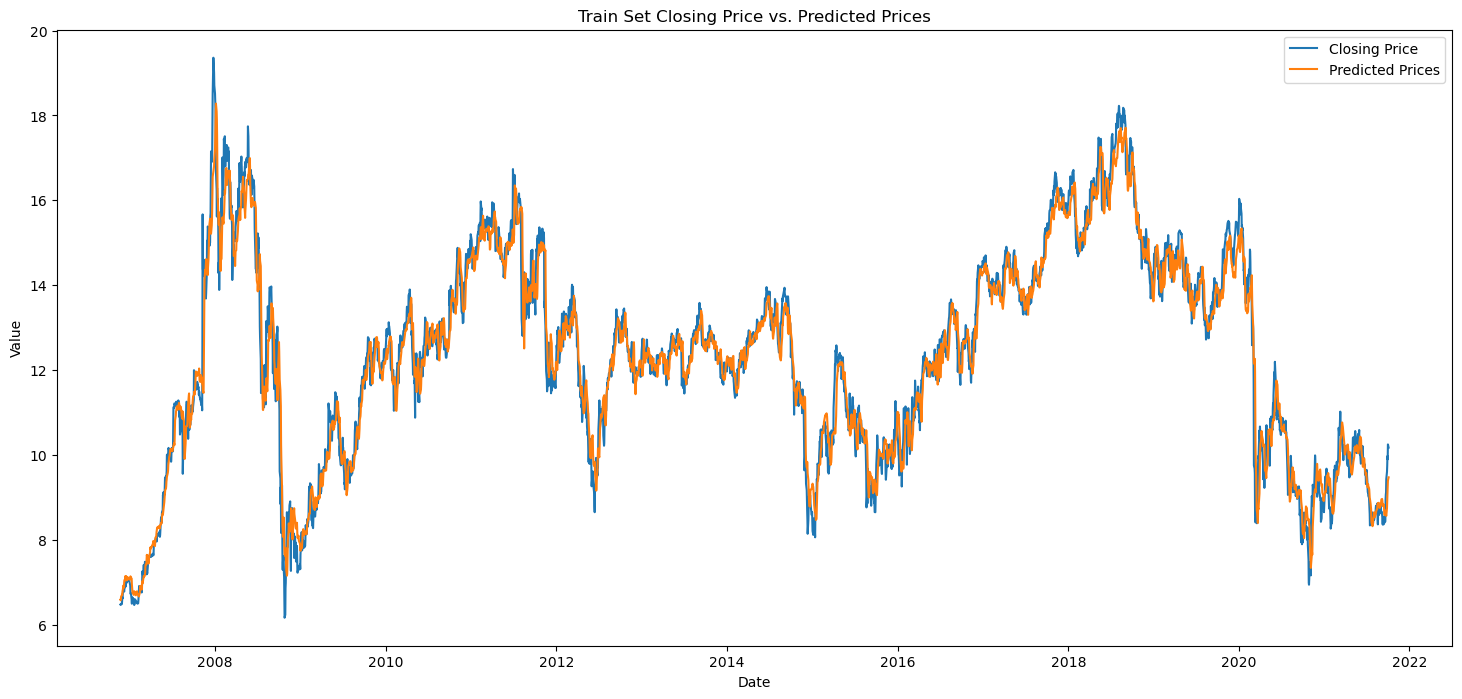

In [71]:
# Load the saved model
loaded_model = load_model('GALP_tuned.h5')
pred_test = loaded_model.predict(X_test)
pred_train = loaded_model.predict(X_train)
pred_test_df = pd.DataFrame(scaler.inverse_transform(pred_test))
pred_train_df = pd.DataFrame(scaler.inverse_transform(pred_train))
closing_test = pd.DataFrame(scaler.inverse_transform(y_test))
closing_train = pd.DataFrame(scaler.inverse_transform(y_train))
rmse_train = np.sqrt(mean_squared_error(closing_train, pred_train_df))
rmse_test = np.sqrt(mean_squared_error(closing_test, pred_test_df))
print(f"RMSE tarin is:  {rmse_train}")
print(f"RMSE test is:  {rmse_test}")

# Plot the desired output and predicted prices against the dates
plt.plot(train_features[20:].index, closing_train.values, label='Closing Price')
plt.plot(train_features[20:].index, pred_train_df.values, label='Predicted Prices')

# Add labels and title to the plot
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('Train Set Closing Price vs. Predicted Prices')
plt.show()



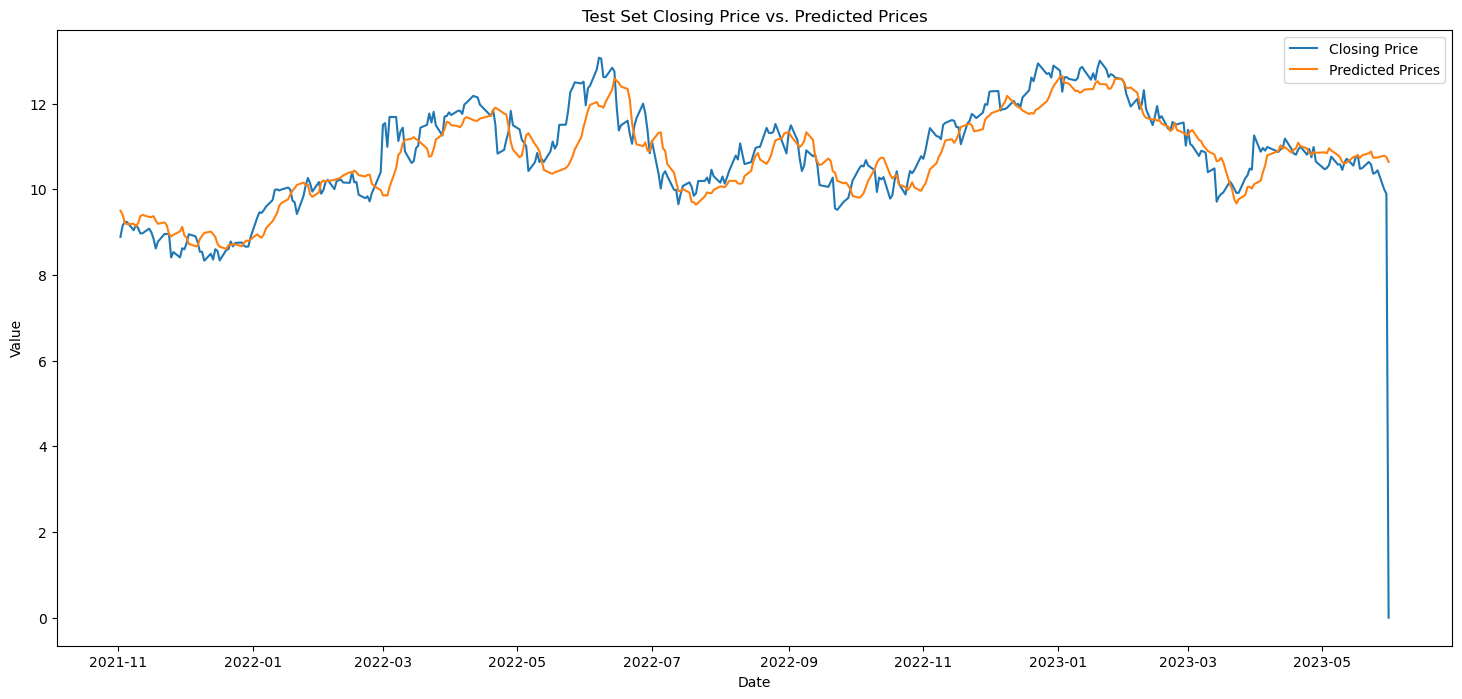

In [72]:
# Plot the desired output and predicted prices against the dates
plt.plot(test_features[20:].index, closing_test.values, label='Closing Price')
plt.plot(test_features[20:].index, pred_test_df.values, label='Predicted Prices')

# Add labels and title to the plot
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('Test Set Closing Price vs. Predicted Prices')
plt.show()



## Based on the above parameter final module:


Epoch 1/10
191/191 [==============================] - 12s 29ms/step - loss: 0.0060
Epoch 2/10
191/191 [==============================] - 5s 25ms/step - loss: 0.0019
Epoch 3/10
191/191 [==============================] - 4s 23ms/step - loss: 0.0015
Epoch 4/10
191/191 [==============================] - 5s 28ms/step - loss: 0.0012
Epoch 5/10
191/191 [==============================] - 5s 28ms/step - loss: 0.0011
Epoch 6/10
191/191 [==============================] - 5s 28ms/step - loss: 0.0010
Epoch 7/10
191/191 [==============================] - 5s 25ms/step - loss: 9.9640e-04
Epoch 8/10
191/191 [==============================] - 5s 25ms/step - loss: 9.8399e-04
Epoch 9/10
191/191 [==============================] - 5s 25ms/step - loss: 0.0011
Epoch 10/10
13/13 [==============================] - 1s 15ms/step


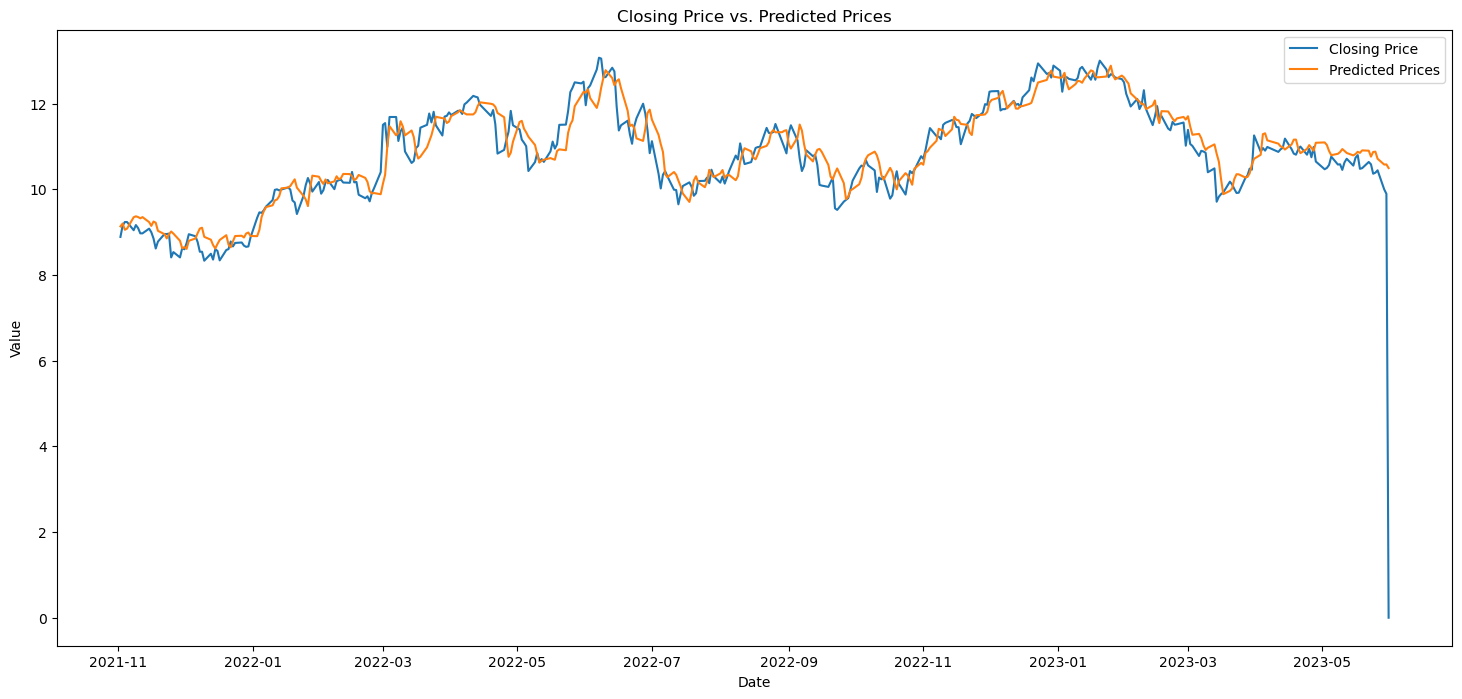

RMSE for test data is: 0.6410537862665627
r2 for test data is : 0.7319434258608366
predicted price for tomorrow based on todays date of 2023-05-31 00:00:00+01:00 is 405    10.63974
Name: 0, dtype: float32


In [134]:
# Build the model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(125, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# Train the model

model.fit(X_train, y_train, epochs=13, batch_size=20)


# Make predictions
predicted_prices = model.predict(X_test)
# Inverse transform the predicted prices
predicted_prices = scaler.inverse_transform(predicted_prices)
pred_df = pd.DataFrame(predicted_prices)
# Inverse transform the actual prices
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Claculate MSE
error = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
r2 = r2_score(actual_prices, predicted_prices)


# Plot the desired output and predicted prices against the dates
plt.plot(test_features[window_size:].index, actual_prices, label='Closing Price')
plt.plot(test_features[window_size:].index, predicted_prices, label='Predicted Prices')

# Add labels and title to the plot
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('Closing Price vs. Predicted Prices')
plt.show()
print(f"RMSE for test data is: {error}")
print(f"r2 for test data is : {r2}")
print(f"predicted price for tomorrow based on todays date of {test_features[20:].index[-1]} is {pred_test_df[0][-1:]}")